# Commodity crush spread statistical arbitrage

This notebook investigates the analysis done in Simon 1999 which is about the crush spread in soybean complex. The crush spread in soybean (soybean, soybean mean and soybeam oil) appears to be mean-reverting both in the short-term and long-term. The author suggests to employ a mean-reversion strategy to capture this price pattern.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.analytics import rebase
from vivace.backtest.contract import InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, Weighting
from vivace.backtest.stats import Performance

# The soybean crush spread

## USDA estimates 1988

First we get the generic price time-series of the front contracts for soybean, meal and oil.

In [2]:
soybean_1st = BacktestEngine(instrument='S', log_level=logging.WARN)
soybean_1st.run()

In [3]:
soybean_meal_1st = BacktestEngine(instrument='SM', log_level=logging.WARN)
soybean_meal_1st.run()

In [4]:
soybean_oil_1st = BacktestEngine(instrument='BO', log_level=logging.WARN)
soybean_oil_1st.run()

In [5]:
soybean_price = soybean_1st.get_generic_price()
soybean_meal_price = soybean_meal_1st.get_generic_price()
soybean_oil_price = soybean_oil_1st.get_generic_price()

Note that each futures prices use different units. *Ignoreing the inherent leverage* in the futures contracts, they each are priced in the following units:
- Soybean meal price is per 1 ton
- Soybean oil price is per 100 pounds
- Soybean price is per 100 bushels

In [6]:
gcm = (soybean_meal_price.squeeze().div(2000).mul(48) + 
       soybean_oil_price.squeeze().div(100).mul(11) - 
       soybean_price.squeeze().div(100))

The chart below reproduces the gross crush margin estimated by USDA 1988.

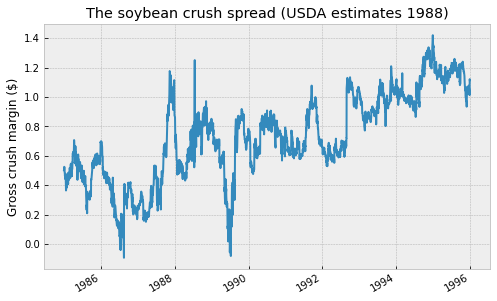

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
gcm['1985':'1995'].plot(ax=ax);
ax.set_ylabel('Gross crush margin ($)')
ax.set_title('The soybean crush spread (USDA estimates 1988)');

The next chart shows a long-term perspective. As mentioned in Simon 1999, this spread does not necessarily represent a long-run equilibrium because the amount of mean and oil can vary depending on the growing condition.

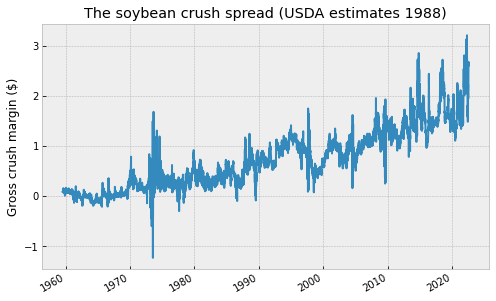

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
gcm.plot(ax=ax);
ax.set_ylabel('Gross crush margin ($)')
ax.set_title('The soybean crush spread (USDA estimates 1988)');

## Long-run equilibrium

In [9]:
price_concat = pd.concat((
    soybean_meal_price,
    soybean_oil_price,
    soybean_price.div(100),
), axis=1).fillna(method='pad').dropna()

In [10]:
month_dummies = pd.get_dummies(pd.Series(price_concat.index.month, index=price_concat.index))
month_dummies = month_dummies.drop(12, axis=1).add_prefix('month_')
trend = pd.Series(range(len(price_concat)), index=price_concat.index, name='trend')

In [11]:
ols_data = pd.concat((price_concat, trend, month_dummies), axis=1)

In [12]:
ols_y = ols_data['S']
ols_x = sm.add_constant(ols_data.drop('S', axis=1))

In [13]:
ols_model = sm.OLS(ols_y.loc['1985':'1995-02'], 
                   ols_x.loc['1985':'1995-02'])
ols_results = ols_model.fit()

The result below is broadly in line with the table 2 in Simon 1999. There is a strong seasonality in this result where the crush spread tends to be lower in the growing season from February to June, while it tends to be higher in September to November. This can be attributed to the relative scarcity in soybeans during the growing season.

In [14]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     8532.
Date:                Tue, 26 Jul 2022   Prob (F-statistic):               0.00
Time:                        06:13:05   Log-Likelihood:                 1652.0
No. Observations:                2565   AIC:                            -3274.
Df Residuals:                    2550   BIC:                            -3186.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6775      0.029     57.663      0.000       1.620       1.735
SM             0.0234   8.33e-05    280.623      0.000       0.023       0.024
BO             0.0846      0.001    124.095      0.000       0.083       0.086
trend         -0.0002   3.68e-06    -63.417      0.000      -0.000      -0.000
month_1        0.0688      0.012      5.669      0.000       0.045       0.093
month_2        0.1370      0.012     11.009      0.000       0.113       0.161
month_3        0.1575      0.012     12.759      0.000       0.133       0.182
month_4        0.1787      0.013     14.246      0.000       0.154       0.203
month_5        0.1826      0.012     14.647      0.000       0.158       0.207
month_6        0.2198      0.012     17.709      0.000       0.195       0.244
month_7        0.1815      0.012     14.629      0.000       0.157       0.206
month_8        0.0923      0.012      7.520      0.000       0.068       0.116
month_9       -0.0001      0.013     -0.011      0.991      -0.025       0.024
month_10      -0.0789      0.012     -6.408      0.000      -0.103      -0.055
month_11      -0.0618      0.013     -4.935      0.000      -0.086      -0.037
==============================================================================
Omnibus:                      141.497   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.206
Skew:                           0.060   Prob(JB):                    2.03e-120
Kurtosis:                       5.268   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For fun, let's run the same model but with more recent data of about the past 10 years.

In [15]:
ols_model = sm.OLS(ols_y.loc['2010':], 
                   ols_x.loc['2010':])
ols_results = ols_model.fit()

This suggests that there is still some seasonality but it became much weaker compared to the result above.

In [16]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.542e+04
Date:                Tue, 26 Jul 2022   Prob (F-statistic):               0.00
Time:                        06:13:05   Log-Likelihood:                -609.67
No. Observations:                3164   AIC:                             1249.
Df Residuals:                    3149   BIC:                             1340.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3972      0.092     26.173      0.000       2.218       2.577
SM             0.0222      0.000    212.773      0.000       0.022       0.022
BO             0.1113      0.001    222.405      0.000       0.110       0.112
trend         -0.0002   5.75e-06    -41.203      0.000      -0.000      -0.000
month_1        0.0282      0.026      1.090      0.276      -0.023       0.079
month_2        0.0298      0.026      1.134      0.257      -0.022       0.081
month_3        0.0330      0.025      1.299      0.194      -0.017       0.083
month_4        0.0496      0.026      1.927      0.054      -0.001       0.100
month_5        0.0027      0.026      0.103      0.918      -0.048       0.053
month_6        0.0814      0.026      3.185      0.001       0.031       0.132
month_7        0.0147      0.026      0.569      0.569      -0.036       0.065
month_8       -0.0629      0.026     -2.437      0.015      -0.114      -0.012
month_9        0.0508      0.026      1.928      0.054      -0.001       0.102
month_10      -0.0711      0.026     -2.754      0.006      -0.122      -0.020
month_11      -0.0584      0.026     -2.222      0.026      -0.110      -0.007
==============================================================================
Omnibus:                      394.825   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              565.552
Skew:                          -0.942   Prob(JB):                    1.56e-123
Kurtosis:                       3.859   Cond. No.                     2.55e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Trading strategy

## 1-1-1 crush spread

As opposed to the one estimated by USDA, or the cointegratioin model estimated by the author, often in practice the crush spread is quoted and traded with 1-1-1 contract sizes. Simon 1999 uses the spread with 100 tons of meal, 60,000 pounds of oil and 5000 bushel of soybeans. 

Incidentally this weighting is roughly equal to the one listed on CME (https://www.cmegroup.com/education/courses/introduction-to-agriculture/grains-oilseeds/understanding-soybean-crush.html), which is the spread with 4,400 pounds (2.2 ton) of meal, 1,100 pounds of oil and 100 bushel of soybeans. 

In [17]:
crush_spread = (soybean_meal_price.squeeze().mul(100) + 
                soybean_oil_price.squeeze().mul(600) - 
                soybean_price.squeeze().mul(50))

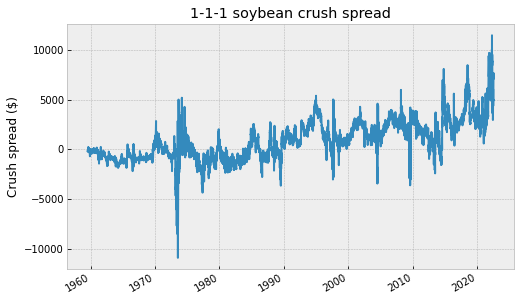

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
crush_spread.plot();
ax.set_ylabel('Crush spread ($)')
ax.set_title('1-1-1 soybean crush spread');

The spread appears mean-reverting around its 5-day moving average.

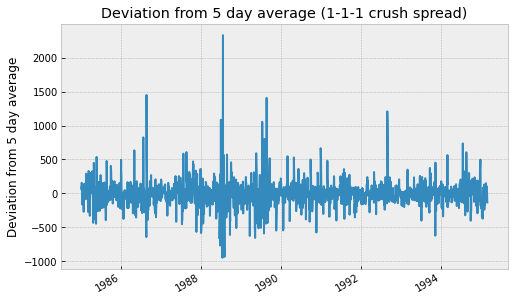

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
(crush_spread - crush_spread.rolling(5).mean())['1985-01':'1995-02'].plot(ax=ax);
ax.set_ylabel('Deviation from 5 day average')
ax.set_title('Deviation from 5 day average (1-1-1 crush spread)');

## Ref CME crush spread

For reference, the crush spread defined by CME follows about the same trajectory.

In [20]:
crush_spread_cme = (soybean_meal_price.squeeze().mul(2.2) + 
                    soybean_oil_price.squeeze().mul(11) - 
                    soybean_price.squeeze())

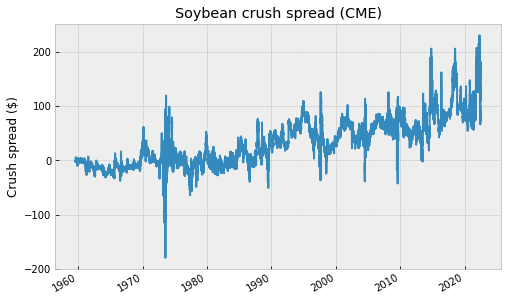

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
crush_spread_cme.plot();
ax.set_ylabel('Crush spread ($)')
ax.set_title('Soybean crush spread (CME)');

## Backtest

In Simon 1999, the author mentions that the trading strategy is performed in-sample, which suggests that the long-run fair value model was fit with the entire data sample. Because of this, the strategy contains a look-ahead bias and **not a valid trading strategy**. A more appropriate simulation would be to use a walk-forward method such as rolling regression.

### Long-only without the fair value model

One minor but important thing is that in `vivace`, usually futures returns are computed as if they are fully-collateralised. This means effectively, return $r_t$ is computed in the form of 

$$
r_t = \frac{F_t - F_{t-1}}{F_{t-1}}
$$

where $F_t$ is the futures price at time $t$.
This is useful when we want to allocate say an equal amount of dollars across different instruments. However in this notebook, we want to decide the allocation based on the nunmber of  lots for each instrument. This is achieved by calculating returns as follows:

$$
r_t = \frac{F_t - F_{t-1}}{c}
$$

where $c$ is the collateral amount. In the following, some arbitrary collateral of 10,000 is used. By doing this $r_t$ means the return relative to the collateral amount (10k).

With this, let's run the backtest with only long-positions on crush spread are taken, without the fair value model.

In [22]:
common_kwargs = dict(
    start_date=datetime(1985, 1, 1),
    end_date=datetime(1995, 2, 28),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[
        InstrumentDef('S', collateral=10000),
        InstrumentDef('SM', collateral=10000),
        InstrumentDef('BO', collateral=10000),
    ],
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)

In [23]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [24]:
long_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

With more strict entry rule.

In [25]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [26]:
long_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [27]:
levels1 = pd.concat((long_only_wo_fair_value.rename('LO: Entry threshold = $100'), 
                     long_only_wo_fair_value2.rename('LO: Entry threshold = $300')), axis=1)

As reported, having more strict entry rule seems to improve the risk-adjusted returns.

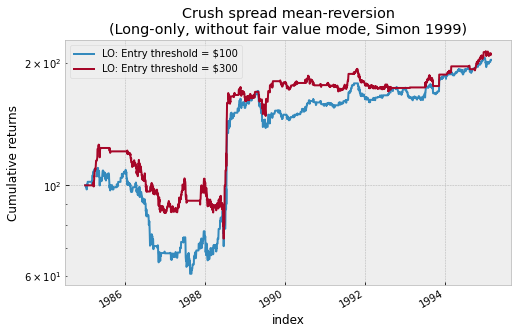

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
levels1.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [29]:
levels1.pipe(Performance).summary()

,LO: Entry threshold = $100,LO: Entry threshold = $300
CAGR,0.069739,0.072783
Annualised vol,0.199714,0.185037
Sharpe ratio,0.349191,0.393345
Max drawdown,0.450240,0.412393
Calmar ratio,0.154892,0.176491
Skewness,10.840016,10.190246
Kurtosis,319.000246,239.627881
Worst return,-0.084068,-0.080780
Worst 1d return,-0.084068,-0.080780
Worst 1w return,-0.115850,-0.111875


### Long-only with the fair value model

In [30]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [31]:
long_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [32]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [33]:
long_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [34]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.2,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [35]:
long_only_with_fair_value3 = engine.calculate_equity_curve(calculate_net=False)

In [36]:
levels2 = pd.concat((long_only_with_fair_value.rename('LO: MA entry = $100, FV entry = 0.0'), 
                     long_only_with_fair_value2.rename('LO: MA entry = $100, FV entry = 0.1'),
                     long_only_with_fair_value3.rename('LO: MA entry = $100, FV entry = 0.2'),), axis=1)

The author tests the fair value threshold of 0.2, however in our analysis this appears to be too strict and the performance is mainly coming from the one-off event in 1988. This suggests that the strategy is sensitive to this parameter and needs to be chosen carefully.

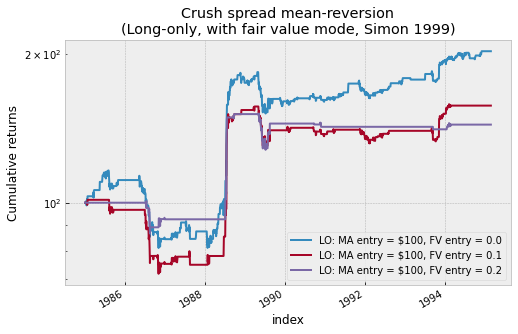

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
levels2.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [38]:
levels2.pipe(Performance).summary()

,"LO: MA entry = $100, FV entry = 0.0","LO: MA entry = $100, FV entry = 0.1","LO: MA entry = $100, FV entry = 0.2"
CAGR,0.069365,0.044459,0.035756
Annualised vol,0.146761,0.152547,0.127055
Sharpe ratio,0.472643,0.291448,0.281420
Max drawdown,0.303265,0.291401,0.155524
Calmar ratio,0.228729,0.152571,0.229905
Skewness,13.922854,19.993458,27.311606
Kurtosis,432.463887,690.302367,1072.661646
Worst return,-0.067862,-0.078377,-0.073372
Worst 1d return,-0.067862,-0.078377,-0.073372
Worst 1w return,-0.054660,-0.061231,-0.049791


### Short-only without the fair value model

Interestingly, the short-only strategy (short SM, BO and long S) shows better risk-adjusted performance during the same period.

In [39]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [40]:
short_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [41]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [42]:
short_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [43]:
levels3 = pd.concat((short_only_wo_fair_value.rename('SO: Entry threshold = $100'), 
                     short_only_wo_fair_value2.rename('SO: Entry threshold = $300')), axis=1)

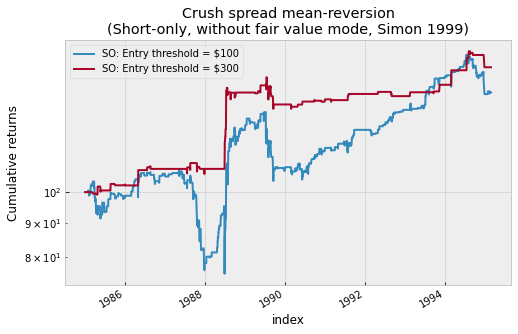

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
levels3.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [45]:
levels3.pipe(Performance).summary()

,SO: Entry threshold = $100,SO: Entry threshold = $300
CAGR,0.033803,0.042297
Annualised vol,0.140158,0.069037
Sharpe ratio,0.241177,0.612677
Max drawdown,0.301009,0.103257
Calmar ratio,0.112299,0.409630
Skewness,0.296796,14.004007
Kurtosis,186.928429,355.269614
Worst return,-0.196615,-0.041517
Worst 1d return,-0.196615,-0.041517
Worst 1w return,-0.100672,-0.041423


### Short-only with the fair value model

In [46]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [47]:
short_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [48]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [49]:
short_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [50]:
levels4 = pd.concat((short_only_with_fair_value.rename('SO: MA entry = $100, FV entry = 0.0'), 
                     short_only_with_fair_value2.rename('SO: MA entry = $100, FV entry = 0.1')), axis=1)

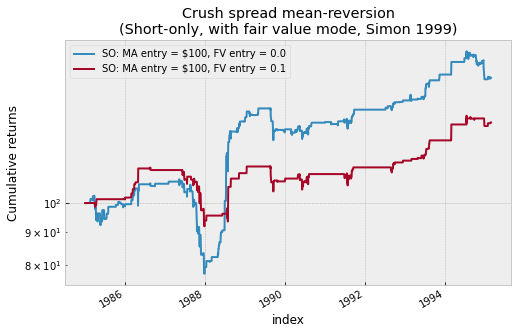

In [51]:
fig, ax = plt.subplots(figsize=(8, 5))
levels4.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [52]:
levels4.pipe(Performance).summary()

,"SO: MA entry = $100, FV entry = 0.0","SO: MA entry = $100, FV entry = 0.1"
CAGR,0.044572,0.028682
Annualised vol,0.103482,0.072472
Sharpe ratio,0.430723,0.395764
Max drawdown,0.289594,0.191797
Calmar ratio,0.153912,0.149543
Skewness,8.561402,10.614582
Kurtosis,187.381076,311.367666
Worst return,-0.060250,-0.035643
Worst 1d return,-0.060250,-0.035643
Worst 1w return,-0.072290,-0.059550


## Long-term performance

In this section, out-of-sample performance is calculated. To be consistent with the previous section, the fair value model is fit using data up to Feb-1995.

In [53]:
common_kwargs = dict(
    start_date=datetime(1985, 1, 1),
    strategy=Strategy.DELTA_ONE.value,
    instrument=[
        InstrumentDef('S', collateral=10000),
        InstrumentDef('SM', collateral=10000),
        InstrumentDef('BO', collateral=10000),
    ],
    weighting=Weighting.SUM.value,
    log_level=logging.WARN,
)

### Long-only without the fair value model

In [54]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [55]:
long_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [56]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [57]:
long_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [58]:
levels1 = pd.concat((long_only_wo_fair_value.rename('LO: Entry threshold = $100'), 
                     long_only_wo_fair_value2.rename('LO: Entry threshold = $300')), axis=1)

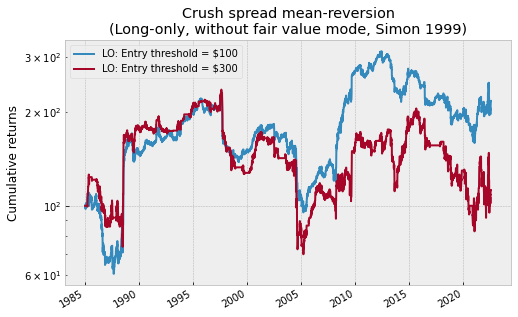

In [59]:
fig, ax = plt.subplots(figsize=(8, 5))
levels1.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [60]:
levels1.pipe(Performance).summary()

,LO: Entry threshold = $100,LO: Entry threshold = $300
CAGR,0.020552,0.003081
Annualised vol,0.149531,0.193168
Sharpe ratio,0.137443,0.015950
Max drawdown,0.584106,0.702229
Calmar ratio,0.035185,0.004387
Skewness,7.206006,3.221012
Kurtosis,285.398697,83.785693
Worst return,-0.084068,-0.127983
Worst 1d return,-0.084068,-0.127983
Worst 1w return,-0.151908,-0.200892


### Long-only with the fair value model

In [61]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [62]:
long_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [63]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=True,
        short_position=False,
    ),
    **common_kwargs,
)
engine.run()

In [64]:
long_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [65]:
levels2 = pd.concat((long_only_with_fair_value.rename('LO: MA entry = $100, FV entry = 0.0'), 
                     long_only_with_fair_value2.rename('LO: MA entry = $100, FV entry = 0.1')), axis=1)

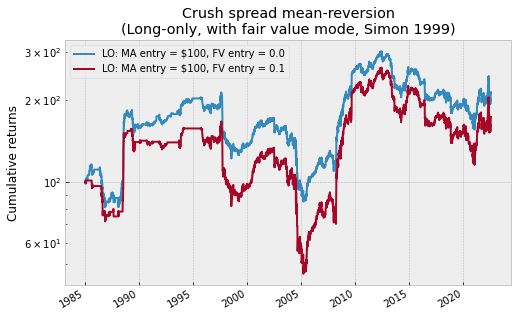

In [66]:
fig, ax = plt.subplots(figsize=(8, 5))
levels2.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Long-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [67]:
levels2.pipe(Performance).summary()

,"LO: MA entry = $100, FV entry = 0.0","LO: MA entry = $100, FV entry = 0.1"
CAGR,0.020173,0.014646
Annualised vol,0.136701,0.171852
Sharpe ratio,0.147572,0.085226
Max drawdown,0.601766,0.723106
Calmar ratio,0.033523,0.020255
Skewness,4.948271,4.137314
Kurtosis,173.474885,141.980054
Worst return,-0.088012,-0.114224
Worst 1d return,-0.088012,-0.114224
Worst 1w return,-0.165488,-0.213097


### Short-only without the fair value model

In [68]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [69]:
short_only_wo_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [70]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=300,
        ma_exit=300,
        fair_value=False,
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [71]:
short_only_wo_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [72]:
levels3 = pd.concat((short_only_wo_fair_value.rename('SO: Entry threshold = $100'), 
                     short_only_wo_fair_value2.rename('SO: Entry threshold = $300')), axis=1)

Again, interestingly, short-only strategy performed well in the out-of-sample period. However it started to underperform since around 2013.

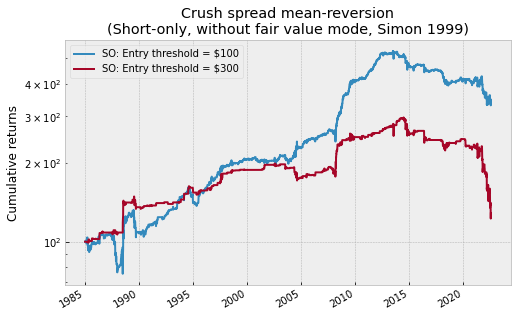

In [73]:
fig, ax = plt.subplots(figsize=(8, 5))
levels3.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [74]:
levels3.pipe(Performance).summary()

,SO: Entry threshold = $100,SO: Entry threshold = $300
CAGR,0.032286,0.006606
Annualised vol,0.094034,0.076951
Sharpe ratio,0.343341,0.085850
Max drawdown,0.377792,0.587792
Calmar ratio,0.085459,0.011239
Skewness,1.108948,4.450677
Kurtosis,269.213629,170.461571
Worst return,-0.196615,-0.070264
Worst 1d return,-0.196615,-0.070264
Worst 1w return,-0.100672,-0.125697


### Short-only with the fair value model

In [75]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [76]:
short_only_with_fair_value = engine.calculate_equity_curve(calculate_net=False)

In [77]:
engine = BacktestEngine(
    signal=signal.CrushSpreadSimon1999InSample(
        ma_lookback=5,
        ma_entry=100,
        ma_exit=100,
        fair_value=True,
        fair_value_entry=0.1,
        fair_value_end_date=datetime(1995, 2, 28),
        long_position=False,
        short_position=True,
    ),
    **common_kwargs,
)
engine.run()

In [78]:
short_only_with_fair_value2 = engine.calculate_equity_curve(calculate_net=False)

In [79]:
levels4 = pd.concat((short_only_with_fair_value.rename('SO: MA entry = $100, FV entry = 0.0'), 
                     short_only_with_fair_value2.rename('SO: MA entry = $100, FV entry = 0.1')), axis=1)

The fair value model almost stopped taking positions in the out-of-sample period because the regression redisual started to drift away from zero. This suggests that the model needs to be refit on a rolling basis.

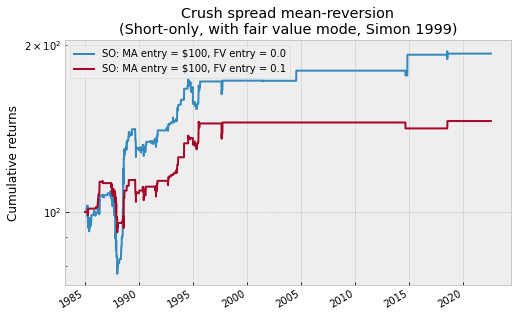

In [80]:
fig, ax = plt.subplots(figsize=(8, 5))
levels4.plot(ax=ax, logy=True);
ax.set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax.set_ylabel('Cumulative returns');

In [81]:
levels4.pipe(Performance).summary()

,"SO: MA entry = $100, FV entry = 0.0","SO: MA entry = $100, FV entry = 0.1"
CAGR,0.017472,0.010033
Annualised vol,0.057395,0.040442
Sharpe ratio,0.304412,0.248088
Max drawdown,0.289594,0.191797
Calmar ratio,0.060332,0.052312
Skewness,14.616824,17.401214
Kurtosis,558.586419,894.978261
Worst return,-0.060250,-0.035643
Worst 1d return,-0.060250,-0.035643
Worst 1w return,-0.072290,-0.059550


# Post publication

In [82]:
publication_date = datetime(1999, 4, 27)

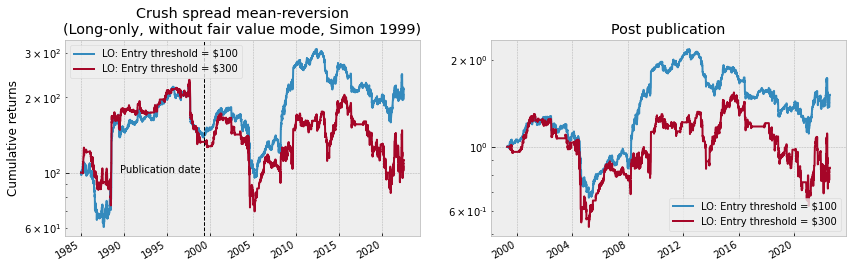

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels1.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Long-only, without fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels1.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

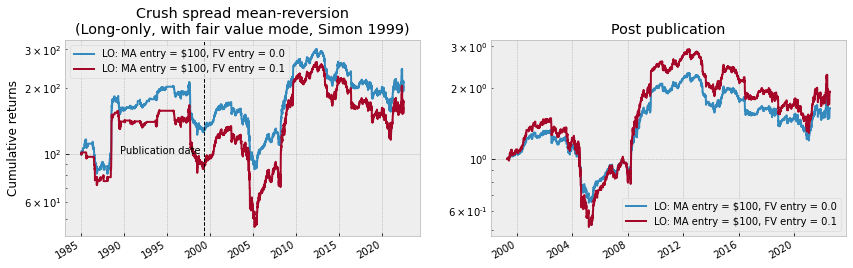

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels2.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Long-only, with fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels2.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

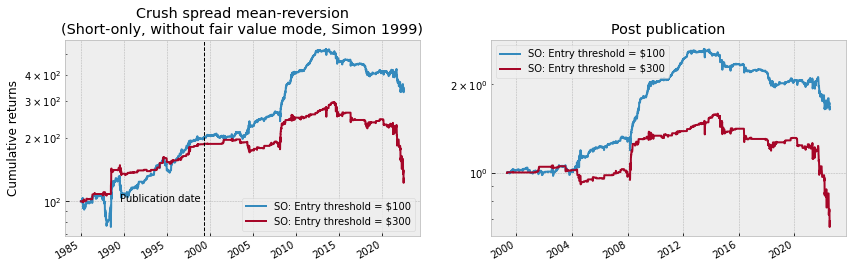

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels3.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Short-only, without fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels3.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

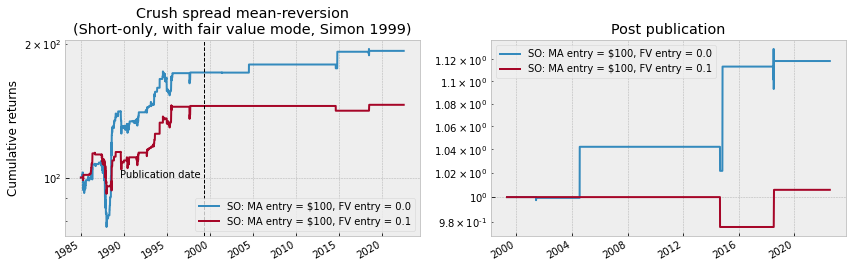

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
levels4.plot(ax=ax[0], logy=True);
ax[0].set_title('Crush spread mean-reversion\n(Short-only, with fair value mode, Simon 1999)')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 100, 'Publication date ', ha='right')

levels4.loc[publication_date:].pipe(rebase).plot(ax=ax[1], logy=True);
ax[1].set_title('Post publication');

# Seasonality

In the regression analysis, we saw that the crush spread tended to be higher in the growing season, and lower in winter. Let's see if this pattern can be captured in a simple long/short strategy.

In [87]:
soybean_1st = BacktestEngine(instrument=InstrumentDef('S', collateral=10000), log_level=logging.WARN)
soybean_1st.run()

In [88]:
soybean_meal_1st = BacktestEngine(instrument=InstrumentDef('SM', collateral=10000), log_level=logging.WARN)
soybean_meal_1st.run()

In [89]:
soybean_oil_1st = BacktestEngine(instrument=InstrumentDef('BO', collateral=10000), log_level=logging.WARN)
soybean_oil_1st.run()

`crush_spread_return` contains returns of a long position in the crush spread (1 lot each).

In [90]:
crush_spread_return = pd.concat((
    soybean_meal_1st.get_return(calculate_net=False).mul(100),
    soybean_oil_1st.get_return(calculate_net=False).mul(600),
    soybean_1st.get_return(calculate_net=False).mul(-50),
), axis=1).fillna(0).sum(axis=1)

In [91]:
seasonality = crush_spread_return.to_frame('return').assign(
    growing=lambda df: -1 * df['return'].where((df.index.month >= 2) & (df.index.month <= 6)),
    winter=lambda df: df['return'].where((df.index.month >= 9) & (df.index.month <= 11)),
).fillna(0).assign(
    long_short=lambda df: df['growing'] + df['winter']
).add(1).cumprod().rename(columns={
    'return': 'Unconditional long',
    'growing': 'Short growing season',
    'winter': 'Long winter',
    'long_short': 'Short growing season + long winter',
})

The result is consistent with the regression, however it doesn't look a very attractive strategy.

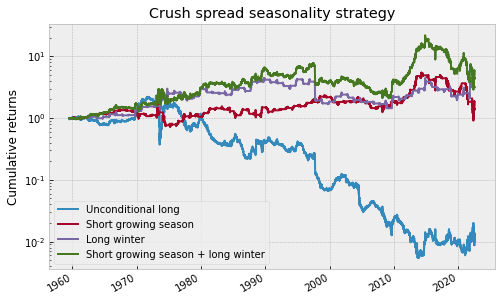

In [92]:
fig, ax = plt.subplots(figsize=(8, 5))

seasonality.plot(ax=ax, logy=True);
ax.set_title('Crush spread seasonality strategy')
ax.set_ylabel('Cumulative returns');

In [93]:
seasonality.pipe(Performance).summary()

,Unconditional long,Short growing season,Long winter,Short growing season + long winter
CAGR,-0.069039,0.005300,0.018269,0.023570
Annualised vol,0.339100,0.208625,0.148671,0.256166
Sharpe ratio,-0.203596,0.025406,0.122881,0.092009
Max drawdown,0.997636,0.833329,0.677156,0.868744
Calmar ratio,-0.069203,0.006361,0.026979,0.027131
Skewness,-0.081009,-0.113679,1.148769,0.142068
Kurtosis,33.201355,63.860176,108.008656,39.003502
Worst return,-0.344800,-0.250000,-0.220000,-0.250000
Worst 1d return,-0.344800,-0.250000,-0.220000,-0.250000
Worst 1w return,-0.645670,-0.343003,-0.286831,-0.343003


# Note
- As mentioned above, the fair value model is fit using data until Feb-1995. This means the performance before this period is in-sample and hence not a valid trading strategy
- The trading strategy appears to be highly sensitive to the threshold for the fair value model
- The regression and backtest suggest that the fair value model is time-varying which means the model needs to be refit on a regular basis

# Reference
- Mitchell, J.B., 2010. Soybean futures crush spread arbitrage: Trading strategies and market efficiency. Journal of Risk and Financial Management, 3(1), pp.63-96.
- Simon, D.P., 1999. The soybean crush spread: Empirical evidence and trading strategies. Journal of Futures Markets: Futures, Options, and Other Derivative Products, 19(3), pp.271-289.

In [94]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 26-Jul-2022 06:22
